# Investigating ANM for toy analysis

## Author: Alexandra Semposki

### Date last edited: 09 September 2024

We'll play with GPs here so that we do not have to mess up the true result notebook that we've been working with.

In [1]:
# import needed packages
%load_ext autoreload
%autoreload 2

import sys
import arviz as az
sys.path.append('../src/')
import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from scipy.linalg import block_diag
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

from gp_utils import GaussianProcessRegressor2dNoise
from eos_utils import *
from tov_utils import *
from scripts import *
from pqcd_reworked import PQCD

import sys
sys.path.append('../../../TOV_Solver')
from TOV_class import TOVsolver

# set params for plotting
setup_rc_params()

# define saturation up here
n0 = 0.164

---

## Setting up the training data <a id="setup"></a>

First, we load in the data sets from $\chi$EFT and pQCD from which we will select training points, and choose the N3LO and N2LO results, respectively. Notice that we are using the results from pure $\chi$EFT, up to $2n_{0}$ only, since GPs do not need to have training points across the entire space to be used.

In [2]:
data_xeft = np.load('../data/NSM_data/chiral_nsm_scaled.npz')
print(data_xeft['density'].shape)
data_pqcd = np.load('../data/eos_data/pressure_pqcd_data_scaled_NSM.npz')

(600,)


Now we do some Python gymnastics to obtain the training points we'd like to use.

In [3]:
# call training function to obtain desired data (for both data sets) (change now to test)
data_xeft_2 = {
    'density': data_xeft['density'][::2],
    'mean': data_xeft['mean'][::2],
    'std_dev': data_xeft['std_dev'][::2],
    'cov': data_xeft['cov'][::2,::2]
}

cutoff = 40
chiral_tr_data, pqcd_tr_data, training_data_new = gp_data(data_xeft_2, data_pqcd, cutoff, all_orders=False)

# assign testing array (no equal points in training)
density_test = np.linspace(0.05, 0.4, 600)[:-1]

(17,) (17,) (17,) (17, 17)
(17,) (17,) (17,) (17, 17)
(4,) (4,) (4,) (4, 4)
Cov shape: (21, 21)


The cell below shows the results that we obtained for Table II in the paper (Sec. IV B). 

In [30]:
# make training data out of the first set
chiral_tr_final = {
    'dens': chiral_tr_data['dens'][1::4],
    'mean': chiral_tr_data['mean'][1::4],
    'std': chiral_tr_data['std'][1::4],
    'cov': chiral_tr_data['cov'][1::4,1::4]
}

# make two dicts out of just the chiral data
training_data_2 = {
    'dens': chiral_tr_data['dens'][::3],
    'mean': chiral_tr_data['mean'][::3],
    'std': chiral_tr_data['std'][::3],
    'cov': chiral_tr_data['cov'][::3,::3]
}
training_data = chiral_tr_final

pqcd_tr_final = {
    'dens': pqcd_tr_data['dens'],
    'mean': pqcd_tr_data['mean'],
    'std': pqcd_tr_data['std'],
    'cov': pqcd_tr_data['cov']
}

# training_data = {
#     'dens': np.concatenate((chiral_tr_final['dens'], pqcd_tr_data['dens'])),
#     'mean': np.concatenate((chiral_tr_final['mean'], pqcd_tr_data['mean'])),
#     'std': np.concatenate((chiral_tr_final['std'], pqcd_tr_data['std'])),
#     'cov': block_diag(chiral_tr_final['cov'], pqcd_tr_data['cov'])
# }

# training_data_2 = {
#     'dens': np.concatenate((chiral_tr_data['dens'], pqcd_tr_data['dens'])),
#     'mean': np.concatenate((chiral_tr_data['mean'], pqcd_tr_data['mean'])),
#     'std': np.concatenate((chiral_tr_data['std'], pqcd_tr_data['std'])),
#     'cov': block_diag(chiral_tr_data['cov'], pqcd_tr_data['cov'])
# }

# print training data for Table II results
print('Density: \n', training_data['dens'])
print('\nMean: \n', training_data['mean'])
print('\nStd dev: \n', training_data['std'])

print('\nDensity: \n', training_data_2['dens'])
print('\nMean: \n', training_data_2['mean'])
print('\nStd dev: \n', training_data_2['std'])

Density: 
 [0.10519199 0.16716194 0.22913189 0.29110184]

Mean: 
 [0.04985287 0.10126424 0.16981855 0.23691277]

Std dev: 
 [0.00563349 0.01520166 0.03054446 0.05340416]

Density: 
 [0.0896995  0.13617696 0.18265442 0.22913189 0.27560935 0.32208681]

Mean: 
 [0.04214668 0.0722059  0.11744224 0.16981855 0.22138206 0.26359562]

Std dev: 
 [0.00402032 0.00979158 0.0184416  0.03054446 0.04684664 0.06854947]


Now we get ready to plot the selected training data and the total means and uncertainties from the two theories. $\chi$EFT and pQCD are always displayed in red and blue, respectively.

In [31]:
errorbar_kwargs = dict(
    capsize=3,
    ecolor="k",
    ls="none",
    marker="o",
    markerfacecolor="k",
    markeredgecolor="k",
    markersize=3
)

errorbar_kwargs_2 = dict(
    capsize=3,
    ecolor="r",
    ls="none",
    marker="o",
    markerfacecolor="r",
    markeredgecolor="r",
    markersize=3
)

In [32]:
# chiral EFT data 
n_xeft = data_xeft['density']
p_mean_xeft = data_xeft['mean']
p_stdv_xeft = data_xeft['std_dev']
p_cov_xeft = data_xeft['cov']

# get the pqcd curve to only plot greater than the cutoff choice
ind_cut = np.where(data_pqcd['density']/n0 >= cutoff)[0][0]

# pQCD data
n_pqcd = data_pqcd['density'][ind_cut:]
p_mean_pqcd = data_pqcd['mean'][ind_cut:, -1]
p_stdv_pqcd = data_pqcd['std_dev'][ind_cut:, -1]
p_cov_pqcd = data_pqcd['cov'][ind_cut:, ind_cut:, -1]

Now we'll plot the current data sets with the cutoffs implemented for each, and the training points that we will be using to train the GP.

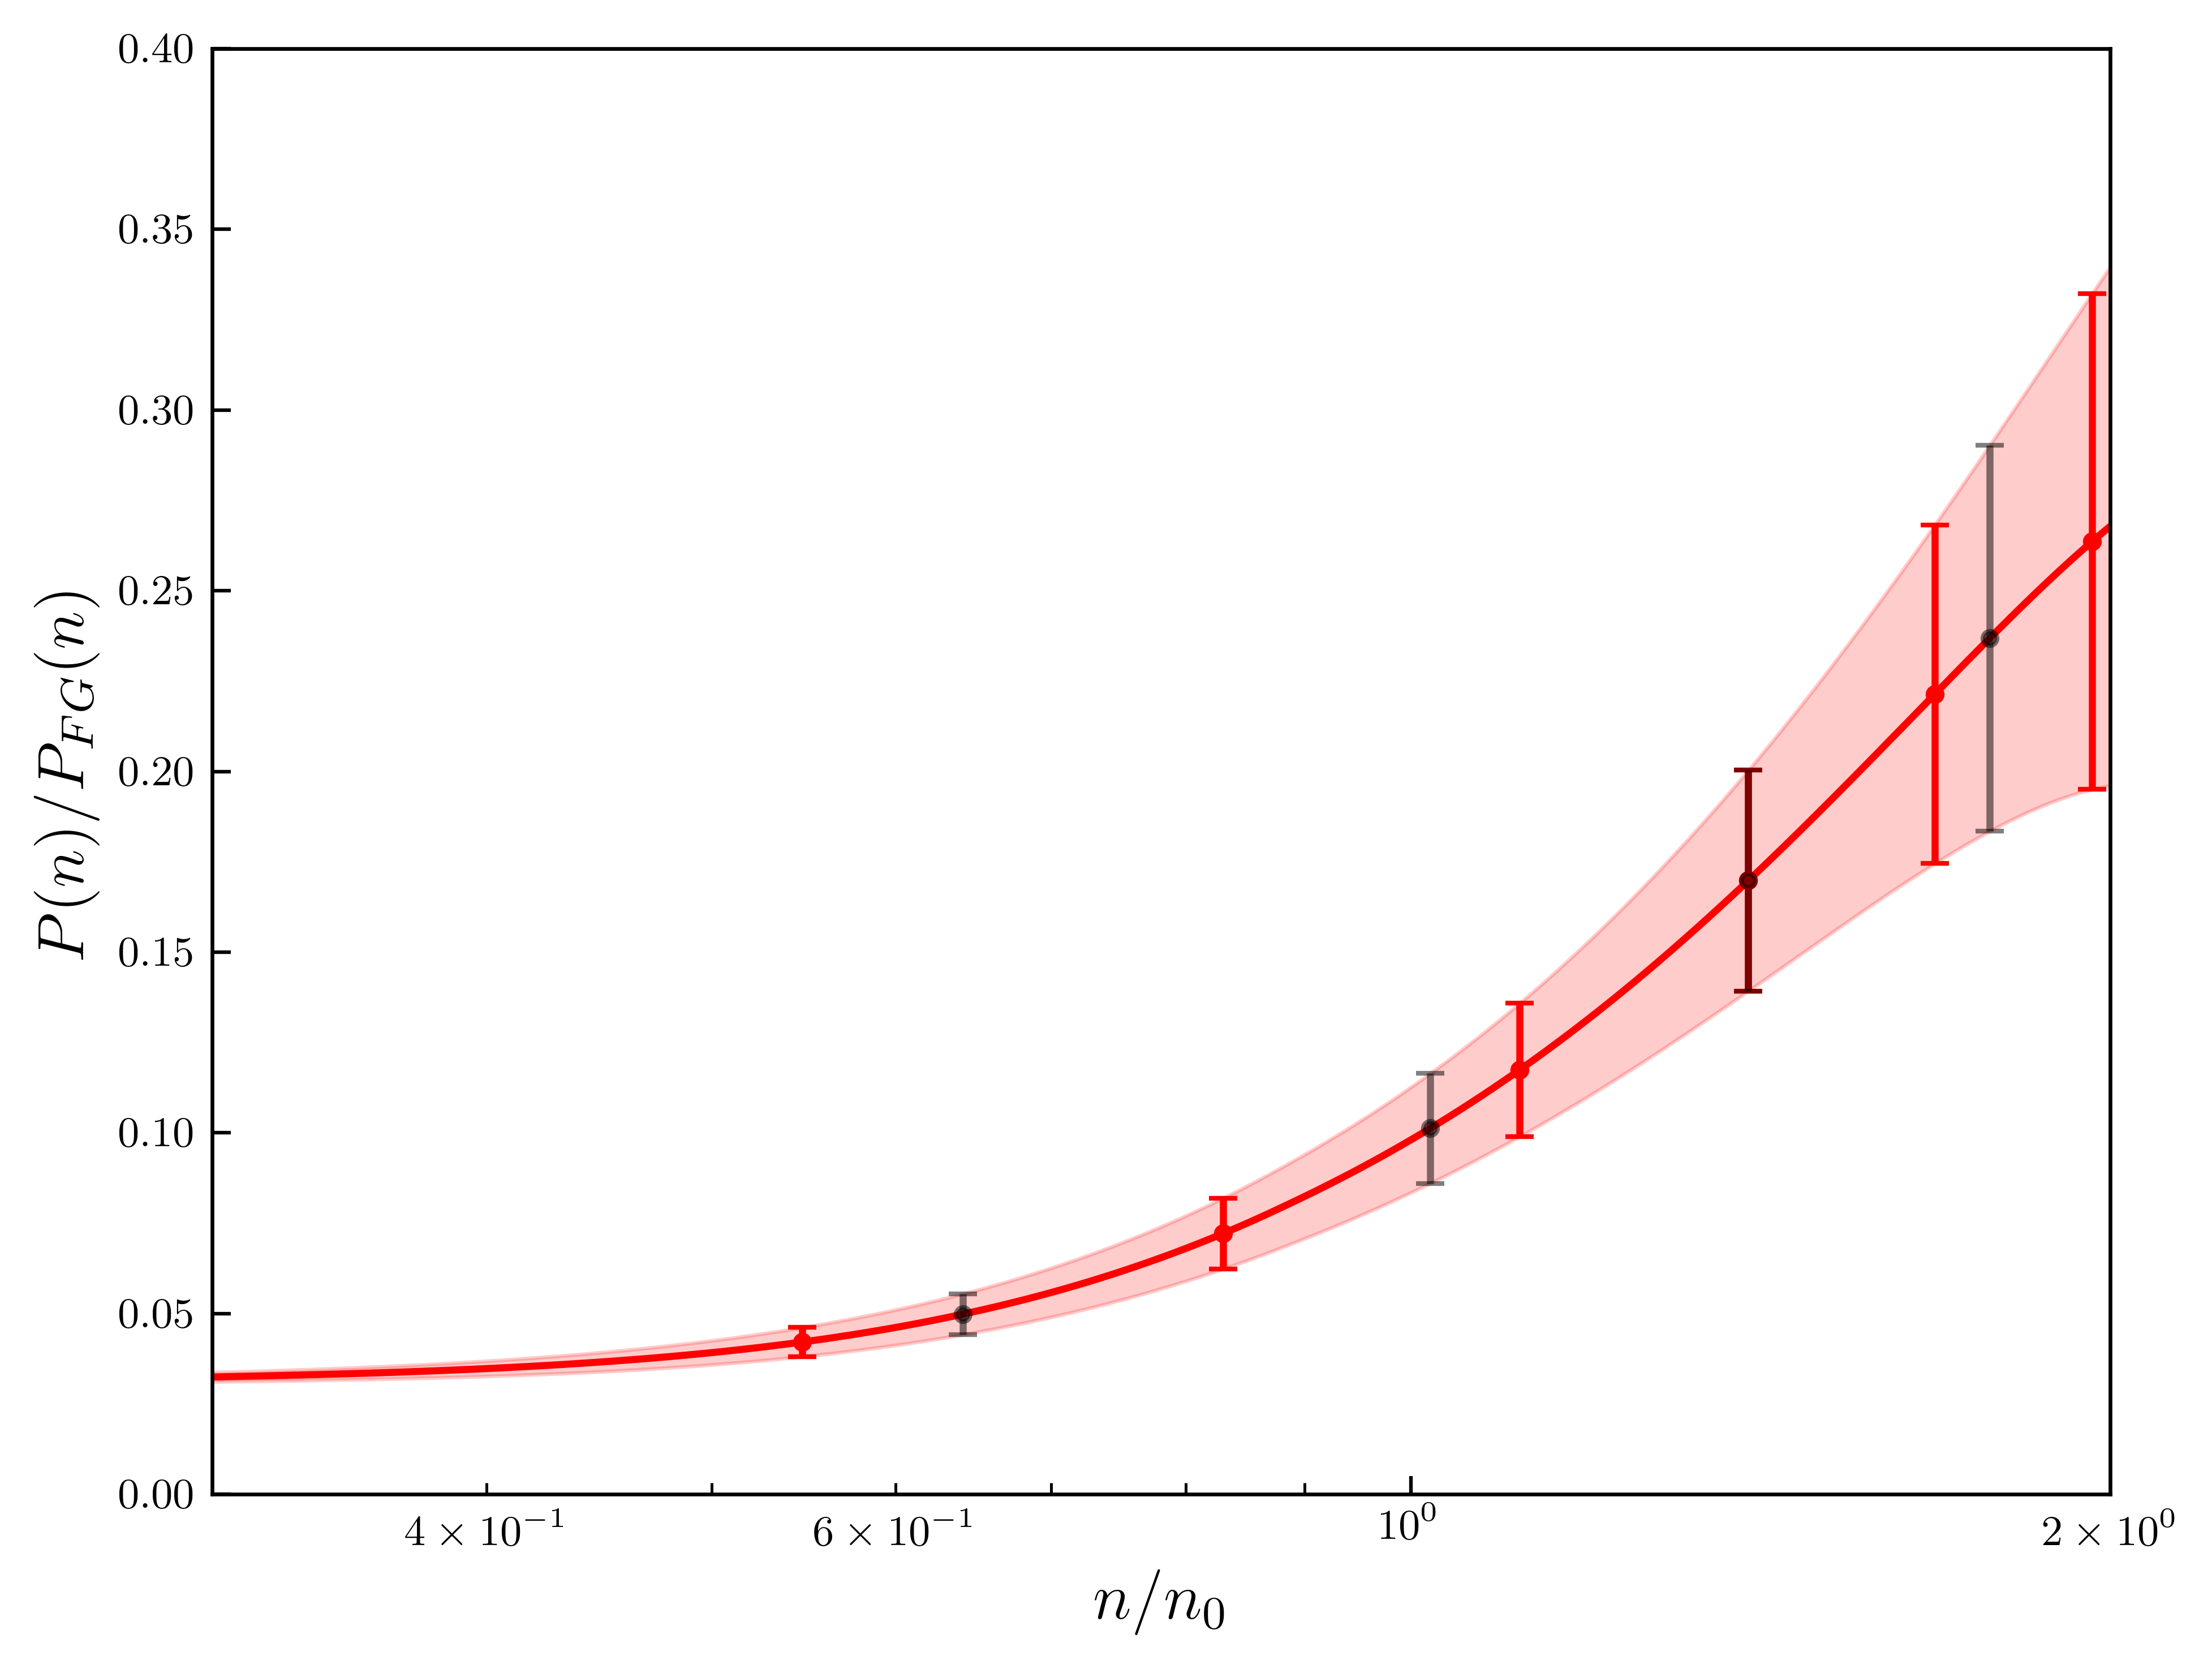

In [33]:
# plot the current data sets
fig, ax = plt.subplots(dpi=600)
ax: Axes
color_xeft = "red"
color_xeft_2 = 'green'
color_pqcd = "blue"
ax.set_xlim(min(density_test)/n0, 2.0)
ax.set_ylim(0.0, 0.4)
ax.set_xscale('log')
ax.set_ylabel(r'$P(n)/P_{FG}(n)$', fontsize=14)
ax.set_xlabel(r'$n/n_{0}$', fontsize=14)

# result of idea 1
ax.plot(n_xeft/n0, p_mean_xeft, color='red', label=r'ChEFT (N3LO)')
ax.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, \
                alpha=0.2, color=color_xeft)
ax.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
            **errorbar_kwargs_2)
ax.errorbar(x=training_data['dens']/n0, y=training_data['mean'], yerr=training_data['std'], \
            **errorbar_kwargs, alpha=0.5)
#ax.plot(n_pqcd/n0, p_mean_pqcd, color='blue', label=r'pQCD (N2LO)')
#ax.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.2, color=color_pqcd)
plt.show()

## Calculation of $P(n)$ using a GP <a id="calc_p_n"></a>

Now we construct the kernel we wish to use, the RBF * constant kernel. Then we will feed this to the `GaussianProcessRegressor2dNoise` function that ties to `sklearn`, and fit to the training data we selected.

We also need to compare the results of the work with the comparison of what happens when I use the same covariance matrix, and fix the lengthscale to reflect the two kernels I see when I work on the RBF kernel with two different covariance matrices.

In [34]:
# choose kernel
if cutoff == 40:
    kernel = C(constant_value=1.1, constant_value_bounds=[0.3,2.25]) * \
    RBF(length_scale=1.1, length_scale_bounds=[0.6,1.2])
#     kernel = C(constant_value=1.0, constant_value_bounds='fixed') \
#     * RBF(length_scale=1.1, length_scale_bounds='fixed')
elif cutoff == 20:
    kernel = C(constant_value=1.1, constant_value_bounds=[0.3,2.25]) * \
    RBF(length_scale=0.8, length_scale_bounds=[0.3, 1.0])
#     kernel = C(constant_value=1.0) \
#     * RBF(length_scale=0.9)

X_train = np.log(training_data['dens']).reshape(-1,1)  # training in the log scale
y_train = training_data['mean'].reshape(-1,1)

X_train_2 = np.log(training_data_2['dens']).reshape(-1,1)  # training in the log scale
y_train_2 = training_data_2['mean'].reshape(-1,1)

# create a small diagonal chicken nugget for the matrix (not needed without a prior?)
nugget = 1e-12*np.diag(np.ones(len(training_data['cov'])))
nugget_2 = 1e-08*np.diag(np.ones(len(training_data_2['cov'])))

In [35]:
# running plot of multiple hyperprior choices
gp = GaussianProcessRegressor2dNoise(
    kernel=kernel,
    alpha=training_data['cov'], #+ nugget,  # here is where we input the full covariance matrix from the data
    n_restarts_optimizer=1000,
)

gp.fit(X_train, y_train, priors=True, cutoff=cutoff, prior_choice='truncnorm_15')  

# running plot of multiple hyperprior choices
gp1 = GaussianProcessRegressor2dNoise(
    kernel=kernel,
    alpha=training_data_2['cov'] + nugget_2,  # here is where we input the full covariance matrix from the data
    n_restarts_optimizer=1000
)

gp1.fit(X_train_2, y_train_2, priors=True, cutoff=cutoff, prior_choice='truncnorm_15')  

GaussianProcessRegressor2dNoise(alpha=array([[1.61729451e-05, 3.78112841e-05, 6.49632388e-05, 9.52086072e-05,
        1.26826401e-04, 1.59449015e-04],
       [3.78112841e-05, 9.58850013e-05, 1.75886895e-04, 2.72775160e-04,
        3.81640972e-04, 5.00577664e-04],
       [6.49632388e-05, 1.75886895e-04, 3.40102576e-04, 5.51993675e-04,
        8.03313820e-04, 1.08961934e-03],
       [9.52086072e-05, 2.72775160e-04, 5.51993675e-04, 9.32974324e-04,
        1.40746490e-03, 1.97031960e-03],
       [1.26826401e-04, 3.81640972e-04, 8.03313820e-04, 1.40746490e-03,
        2.19461776e-03, 3.16604363e-03],
       [1.59449015e-04, 5.00577664e-04, 1.08961934e-03, 1.97031960e-03,
        3.16604363e-03, 4.69903927e-03]]),
                                kernel=1.05**2 * RBF(length_scale=1.1),
                                n_restarts_optimizer=1000)

We can print out the kernel hyperparameters ($\bar{c}$ and $\ell$) below, and see what we get using this kernel.

In [36]:
print(gp.kernel_)
print(gp1.kernel_)

0.943**2 * RBF(length_scale=1.06)
0.919**2 * RBF(length_scale=1.09)


In [37]:
# data peak from log likelihood
log_likelihood = []
log_likelihood_2 = []
ell = np.linspace(0.5, 2.0, 200)

In [38]:
#conversion for speed of sound
convert_pqcd = np.load('../data/eos_data/pqcd_fg_data_NSM.npz')

# interpolate for a functional form to use 
convert_interp = sp.interpolate.interp1d(convert_pqcd['density'], convert_pqcd['mean'], \
                                 kind='cubic', fill_value='extrapolate')
pqcd_convert_arr = convert_interp(density_test)

In [39]:
# use the testing density array now for predicting at new locations (also in log space)
X = np.log(density_test).reshape(-1,1)

y_pred_0, y_stdv_0 = gp.predict(X, return_std=True)
_, y_cov_0 = gp.predict(X, return_cov=True)

y_pred_1, y_stdv_1 = gp1.predict(X, return_std=True)
_, y_cov_1 = gp1.predict(X, return_cov=True)

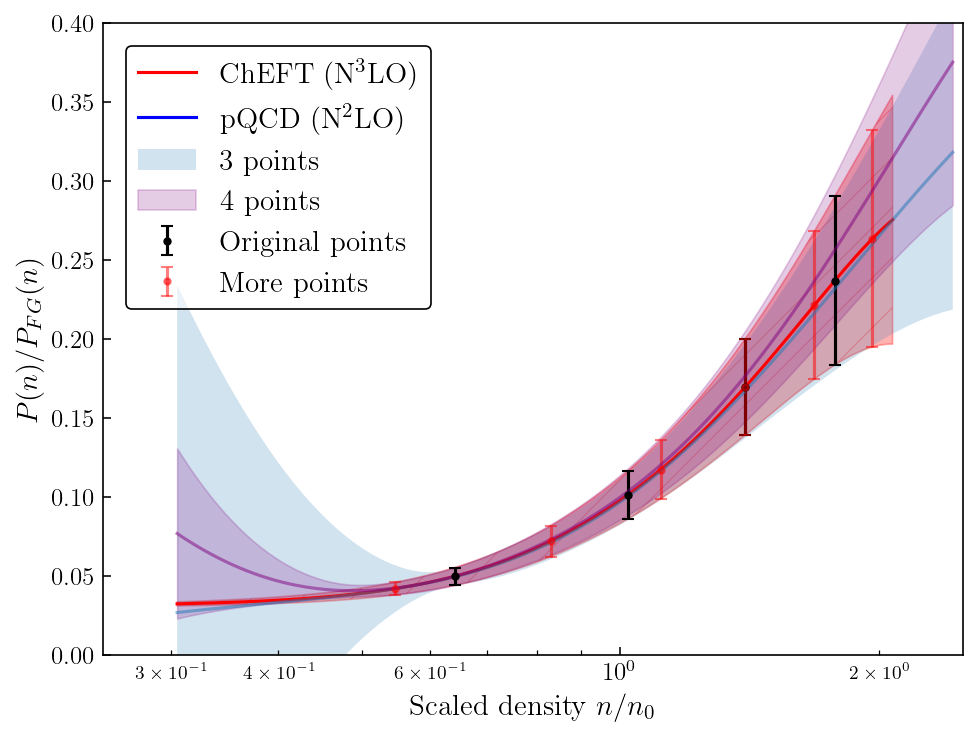

In [40]:
fig, ax = plt.subplots(dpi=150)
ax.set_xlim(min(density_test/n0), 100.0)
ax.set_ylim(0, 1.5)
ax.set_xscale('log') # plot in log base 10
ax.set_xlabel(r'$n/n_{0}$')
ax.set_ylabel(r'$P(n)/P_{FG}(n)$')

# chiral EFT and pQCD curves, training data
ax.plot(n_xeft/n0, p_mean_xeft, color='red', label=r'ChEFT (N$^3$LO)')
ax.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, alpha=0.3, \
                color=color_xeft, hatch='/')
ax.errorbar(x=training_data['dens']/n0, y=training_data['mean'], yerr=training_data['std'], color='k', \
            **errorbar_kwargs, label=r'Original points')
ax.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], color='r', \
            **errorbar_kwargs_2, label=r'More points', alpha=0.5)

ax.plot(n_pqcd/n0, p_mean_pqcd, color='blue', label=r'pQCD (N$^2$LO)')
ax.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.3, color=color_pqcd, \
               hatch='/')

# GP kernel choice results and uncertainty bands
ax.plot(density_test/n0, y_pred_0, alpha=0.5)
ax.plot(density_test/n0, y_pred_1, alpha=0.5, color='purple')
ax.fill_between(density_test/n0, y_pred_0-y_stdv_0, y_pred_0+y_stdv_0, \
                label=r'3 points', \
                alpha=0.2)
ax.fill_between(density_test/n0, y_pred_1-y_stdv_1, y_pred_1+y_stdv_1, \
                label=r'4 points', \
                color='purple', alpha=0.2)

plt.xlim(0.25, 2.5)
plt.ylim(0.0, 0.4)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel(r'Scaled density $n/n_{0}$', fontsize=14)
plt.ylabel(r'$P(n)/P_{FG}(n)$', fontsize=14)
plt.legend(fontsize=14, loc='upper left')
plt.show()

In [41]:
# correlation coefficients with pQCD
# check out the covariance matrix
# print(y_cov_0.shape)
# print(y_cov_1.shape)
# index_2n0 = np.where([density_test[i] >= 0.34 for i in range(len(density_test))])[0][0]
# print([index_2n0])
# index_40n0 = np.where([density_test[i] >= 6.56 for i in range(len(density_test))])[0][0]

# # covariances
# y_var0_2n0 = y_cov_0[index_2n0, index_2n0]
# y_var0_40n0 = y_cov_0[index_40n0, index_40n0]
# y_cross0_2n0_40n0 = y_cov_0[index_2n0, index_40n0]

# # covariances between 5n0 and 40n0 here
# y_var1_2n0 = y_cov_1[index_2n0, index_2n0]
# y_var1_40n0 = y_cov_1[index_40n0, index_40n0]
# y_cross1_2n0_40n0 = y_cov_1[index_2n0, index_40n0]

# # correlation coefficients
# corr_coeff = y_cross0_2n0_40n0 / (np.sqrt(y_var0_2n0) * np.sqrt(y_var0_40n0))
# corr_coeff_2 = y_cross1_2n0_40n0 / (np.sqrt(y_var1_2n0) * np.sqrt(y_var1_40n0))
# print('Correlation coefficient, blue curve: ', corr_coeff)
# print('Correlation coefficient, purple curve: ', corr_coeff_2)

In [42]:
# compare the size of the error bars for both theories below at some select point (last point)
band_chiral = p_stdv_xeft[-1]
band_gp = y_stdv_1[475]  # 2n0
band_gp_2 = y_stdv_0[475]
#band_pqcd = p_stdv_pqcd[0]

# if cutoff == 20:
#     index_pqcd20 = np.where([density_test[i] <= 3.28 for i in range(len(density_test))])[0][-1]
#     band_gp_pqcd = y_stdv_1[index_pqcd20]
# elif cutoff == 40:
#     index_pqcd40 = np.where([density_test[i] <= 6.56 for i in range(len(density_test))])[0][-1]
#     band_gp_pqcd = y_stdv_1[index_pqcd40]
# print('here', band_gp_pqcd)
# print('here 2', band_pqcd)
print('Density at chosen point:', density_test[475], 'fm^-3')

# print out the differences
print('Difference between blue and chiral: ', ((band_chiral - band_gp_2)/(band_chiral))*100)
print('Difference between purple and chiral: ', ((band_chiral - band_gp)/(band_chiral))*100)
#print('Difference between GP and pQCD: ', (np.abs(band_pqcd - band_gp_pqcd)/band_pqcd)*100)

Density at chosen point: 0.32754590984974963 fm^-3
Difference between blue and chiral:  15.26980442913719
Difference between purple and chiral:  23.19450803958505
